<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-08-19 13:40:52--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.002s  

2020-08-19 13:40:52 (11.0 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
Unnamed: 0        346 non-null int64
Unnamed: 0.1      346 non-null int64
loan_status       346 non-null object
Principal         346 non-null int64
terms             346 non-null int64
effective_date    346 non-null object
due_date          346 non-null object
age               346 non-null int64
education         346 non-null object
Gender            346 non-null object
dtypes: int64(5), object(5)
memory usage: 27.1+ KB


### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to understand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    seaborn-0.10.1             |             py_0         160 KB  anaconda
    ca-certificates-2020.6.24  |                0         133 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.2 MB

The following packages will be UPDATED:

    ca-certificates: 2020.6.24-0        --> 2020.6.24-0       anaconda
    certifi:         2020.6.20-py36_0   --> 2020.6.20-py36_0  anaconda
    openssl:         1.1.1g-h7b6447c_0  --> 1.1.1g-h7b6447c_0 anaconda
    seaborn:         0.9.0-pyh91

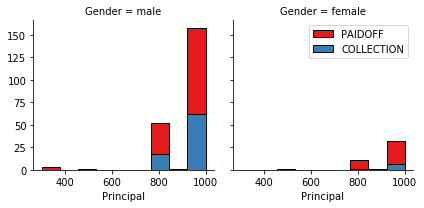

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10) # define axis ticks range bin with even range 10
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2) # Define FacetGrid object from dataset df with Gender as column, loan_status as hue)
g.map(plt.hist, 'Principal', bins=bins, ec="k") # Plotting the FacetGrid object g with Principal as axis and bins defined before as histogram

g.axes[-1].legend() #Insert Legend
plt.show()

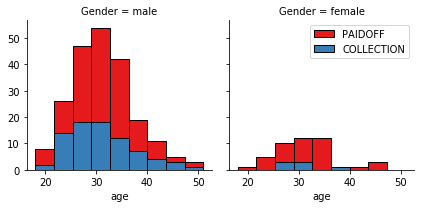

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)# Define FacetGrid object from dataset df with Gender as column, loan_status as hue)
g.map(plt.hist, 'age', bins=bins, ec="k") # Plotting the FacetGrid object g with with age as axis and bins defined before as histogram

g.axes[-1].legend() #Insert Legend
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

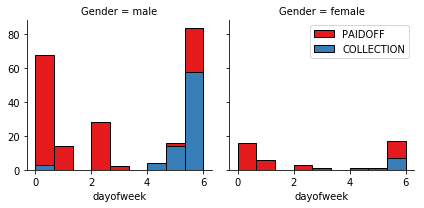

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature before One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets define feature sets, X:

In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


Check our label and define target field, y:

In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

Let's search best K value for the model, by using training dataset and test dataset

In [22]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for k in range(1,Ks):
    Neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    yhat = Neigh.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

    
mean_acc

array([0.67142857, 0.65714286, 0.71428571, 0.68571429, 0.75714286,
       0.71428571, 0.78571429, 0.75714286, 0.75714286])

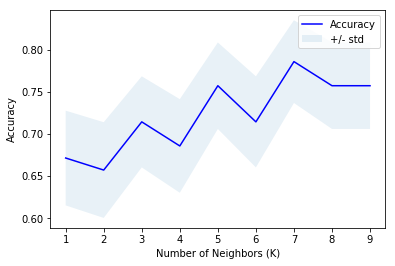

In [23]:
plt.plot(range(1,Ks), mean_acc,'b')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy', '+/- std'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.show()

It's seem the best K values for our model is 7

In [24]:
k = 7
Neigh = KNeighborsClassifier(n_neighbors=k)
Neigh.fit(X_train, y_train)
yhat = Neigh.predict(X_test)
print(yhat[0:5])
print("Test Set Accuracy: ", metrics.accuracy_score(y_test, yhat))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Test Set Accuracy:  0.7857142857142857


Let's train the final model with the whole data


<font color='red'>Notes for fellow reviewer: Model evaluation are calculated on later/last code cell on report table. I am sorry for this note because I found some peers are deducting scores because apparently they think I didn't calculating the model evaluation. I did it on later/last code cells. cheers! </font>

In [25]:
Neigh.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

# Decision Tree

For decision tree model, let's look or optimal maximum depth

[0.78571429 0.78571429 0.61428571 0.61428571 0.64285714 0.77142857
 0.75714286 0.75714286 0.65714286]


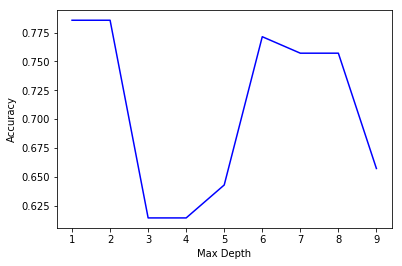

In [28]:
from sklearn.tree import DecisionTreeClassifier
Ds = 10
mean_acc = np.zeros((Ds-1))
std_acc = np.zeros((Ds-1))

for d in range(1,Ds):
    DecTree = DecisionTreeClassifier(criterion="entropy", max_depth= d).fit(X_train, y_train)
    yhat = DecTree.predict(X_test)
    mean_acc[d-1] = metrics.accuracy_score(y_test, yhat)
print(mean_acc)
    
plt.plot(range(1,Ds), mean_acc,'b')
plt.ylabel('Accuracy')
plt.xlabel('Max Depth')
plt.show()    

    


Decision model tree are unable too separate efficiently after second depth. So let's use second level for our final model.

In [29]:
DecTree = DecisionTreeClassifier(criterion="entropy", max_depth=2)
DecTree.fit(X_train, y_train)
yhat1 = DecTree.predict(X_test)
print(yhat1[0:5])    
print("Test Set Accuracy: ", metrics.accuracy_score(y_test,yhat1))



['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Test Set Accuracy:  0.7857142857142857


let's fit the whole dataset for our final model

<font color='red'>Notes for fellow reviewer: Model evaluation are calculated on later/last code cell on report table. I am sorry for this note because I found some peers are deducting scores because apparently they think I didn't calculating the model evaluation. I did it on later/last code cells. cheers! </font>

In [30]:
DecTree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Optional
Let's visualize the decision tree
Warning: It will took a while to install

In [31]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.4 MB

The following NEW packages will be INSTALLED:

    pydotplus:       2.0.2-pyhd1c1de3_3 conda-forge
    python_abi:      3.6-1_cp36m        conda-forge

The following packages will be UPDATED:

 

In [32]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

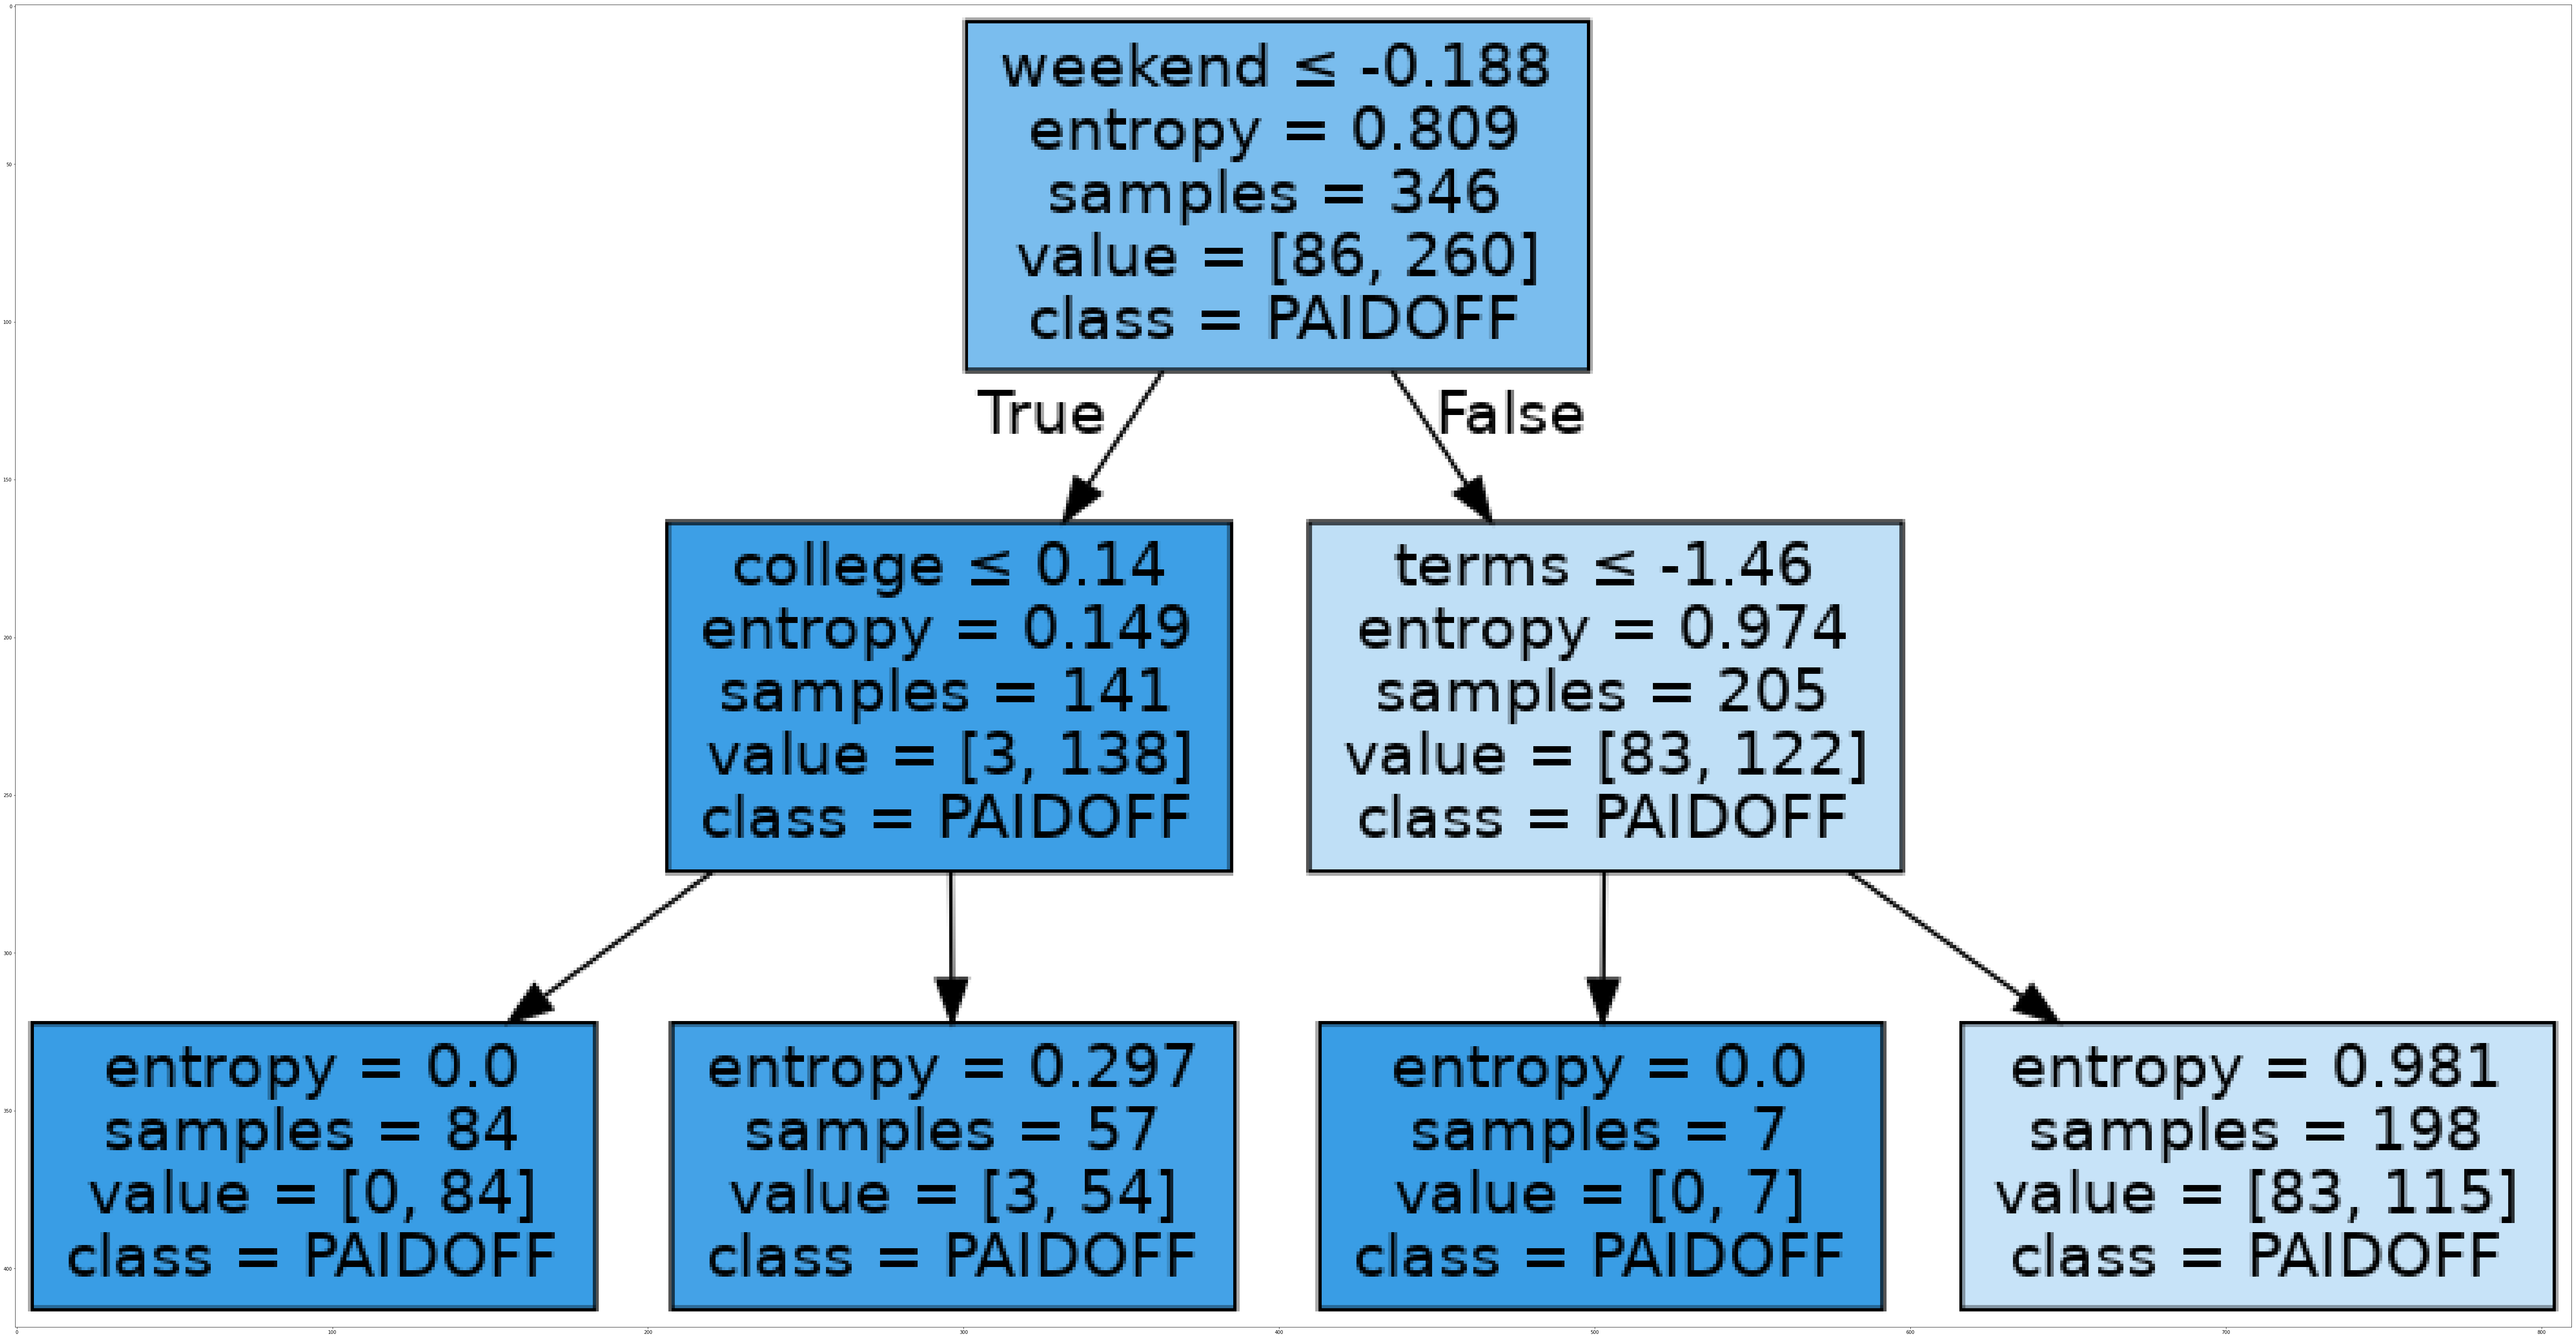

In [33]:
dot_data = StringIO()
filename = "Loan Status Tree.png"
featureNames = Feature.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(DecTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Support Vector Machine

Let's look for the best kernel to be used

In [34]:
from sklearn import svm
Kernel = ['linear', 'poly', 'rbf', 'sigmoid']
mean_acc = np.zeros(len(Kernel))
for i,mode in enumerate(Kernel):
    LoanSVM = svm.SVC(kernel=mode)
    LoanSVM.fit(X_train, y_train)
    yhat2a = LoanSVM.predict(X_test)
    mean_acc[i] = metrics.accuracy_score(y_test, yhat2a)

mean_acc

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.78571429, 0.77142857, 0.74285714, 0.74285714])

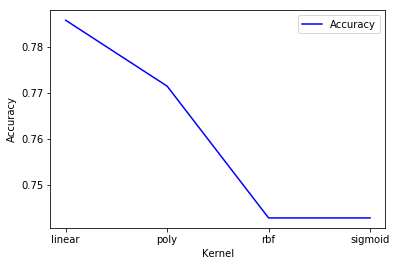

In [35]:
plt.plot(Kernel, mean_acc, 'b')
plt.legend(('Accuracy', '+/- std'))
plt.ylabel('Accuracy')
plt.xlabel('Kernel')
plt.show()

It seems linear kernel are the best kernel for our model, let's fit our final model

<font color='red'>Notes for fellow reviewer: Model evaluation are calculated on later/last code cell on report table. I am sorry for this note because I found some peers are deducting scores because apparently they think I didn't calculating the model evaluation. I did it on later/last code cells. cheers! </font>

In [36]:
LoanSVM1 = svm.SVC(kernel='linear')
LoanSVM1.fit(X_train, y_train)
yhat2 = LoanSVM1.predict(X_test)
print(yhat2[0:5])
print("Test Set Accuracy: ", metrics.accuracy_score(y_test,yhat2))

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Test Set Accuracy:  0.7857142857142857


In [37]:
LoanSVM1.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Logistic Regression

For Logistic Regression model, it's better to choose liblinear solver because it's a better fit for small dataset.

In [38]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(C=0.1, solver='liblinear')
LR.fit(X_train, y_train)
yhat3 = LR.predict(X_test)
print(yhat[0:5])
print("Test Set Accuracy: ", metrics.accuracy_score(y_test, yhat3))

['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Test Set Accuracy:  0.7428571428571429


Let's fit our final model

<font color='red'>Notes for fellow reviewer: Model evaluation are calculated on later/last code cell on report table. I am sorry for this note because I found some peers are deducting scores because apparently they think I didn't calculating the model evaluation. I did it on later/last code cells. cheers! </font>

In [39]:
LR.fit(X,y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

# Model Evaluation using Test set

Let's test all our model by other testing set (outsample data), to see if our model fit properly.

In [40]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-08-19 14:50:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-08-19 14:50:36 (393 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Convert Categorical Values to Numerical Values

In [43]:
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,1
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,0
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,1
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,0
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,0


In [44]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0


In [45]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [46]:
Test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
Test_Feature = pd.concat([Test_Feature,pd.get_dummies(test_df['education'])], axis=1)
Test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
Test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [47]:
X_finaltest = Test_Feature
X_finaltest.head(5)

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [48]:
y_finaltest = test_df['loan_status'].values
print(y_finaltest[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


### Normalize Data

In [49]:
X_finaltest = preprocessing.StandardScaler().fit(X_finaltest).transform(X_finaltest)
X_finaltest[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

### Report

Create the report table

In [52]:
data = [['KNN','','',''],['Decision Tree','','',''],['SVM','','',''],['LogisticRegression','','','']]
column = ['Algorithm', 'Jaccard', 'F1-score','LogLoss']
report_df = pd.DataFrame(data=data, columns=column)
report_df.index=report_df['Algorithm']
report_df.drop(columns='Algorithm', axis=1, inplace=True)
report_df.head(5)

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,,,
Decision Tree,,,
SVM,,,
LogisticRegression,,,


Let's fill the report

In [53]:
yhat0 = Neigh.predict(X_finaltest)
yhat1 = DecTree.predict(X_finaltest)
yhat2 = LoanSVM1.predict(X_finaltest)
yhat3 = LR.predict(X_finaltest)
yhat3prob = LR.predict_proba(X_finaltest)
Jaccard = np.zeros(4)
F1_score = np.zeros(4)
LogLoss = ('NA','NA', 'NA', log_loss(y_finaltest, yhat3prob))
Prediction_Value = (yhat0, yhat1, yhat2, yhat3)
Eval_Method = (Jaccard, F1_score, LogLoss)
for i,value in enumerate(Prediction_Value):
    Jaccard[i] = jaccard_similarity_score(y_finaltest, value)
    F1_score[i] = f1_score(y_finaltest, value, average='weighted')
    
  

for a,b in zip(report_df.columns, Eval_Method):
    report_df[a] = b

report_df


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.722222,0.700199,NA
Decision Tree,0.740741,0.630418,NA
SVM,0.740741,0.630418,NA
LogisticRegression,0.759259,0.671764,0.480035


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.72       | 0.70        | NA      |
| Decision Tree      | 0.74       | 0.63        | NA      |
| SVM                | 0.74       | 0.63        | NA      |
| LogisticRegression | 0.76       | 0.67        | 0.48       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>